# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Understanding

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# Data Processing

In [10]:
profile['gender'].fillna('O', inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)

In [11]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [12]:
channels_set = set()
for i in portfolio['channels']:
    channels_set.update(set(i))
channels_set  

{'email', 'mobile', 'social', 'web'}

In [13]:
for j in channels_set:
    portfolio[j] = portfolio['channels'].apply(lambda a: j in a).map({True:1, False: 0}) 

In [14]:
portfolio = portfolio.drop('channels', axis=1)
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,web,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [15]:
transcript['amount'] = transcript[transcript['event'] == 'transaction'].value.apply(lambda i:list(i.values())[0])

In [16]:
transcript['re'] = transcript[transcript['event'] == 'offer completed'].value.apply(lambda i:list(i.values())[1])

In [17]:
transcript['offer_id'] = transcript[transcript['event'] != 'transaction'].value.apply(lambda i:list(i.values())[0])

In [18]:
transcript['offer_completed'] = transcript['event'].apply(lambda x: 1 if x == 'offer completed' else 0)

In [19]:
portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
profile.rename(columns = {'id': 'customer_id'}, inplace = True)

In [20]:
transcript = transcript.drop('value', axis=1)
transcript.head()

,customer_id,event,time,amount,re,offer_id,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0


# Data Analysis

1. Distribution of income

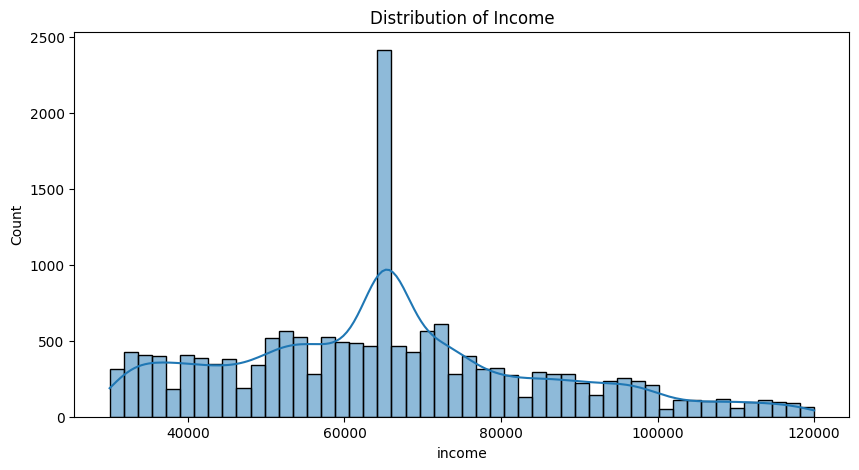

In [64]:
plt.figure(figsize = (10,5))
sns.histplot(profile['income'], bins=50, kde=True)
plt.title('Distribution of Income')
plt.savefig('fig1.png', bbox_inches='tight')
plt.show()

In [28]:
profile['income'].mean()

65404.9915682968

The income is skewed to the right a little bit. It seems like the majority is around $65000

2. Distribution of Age 

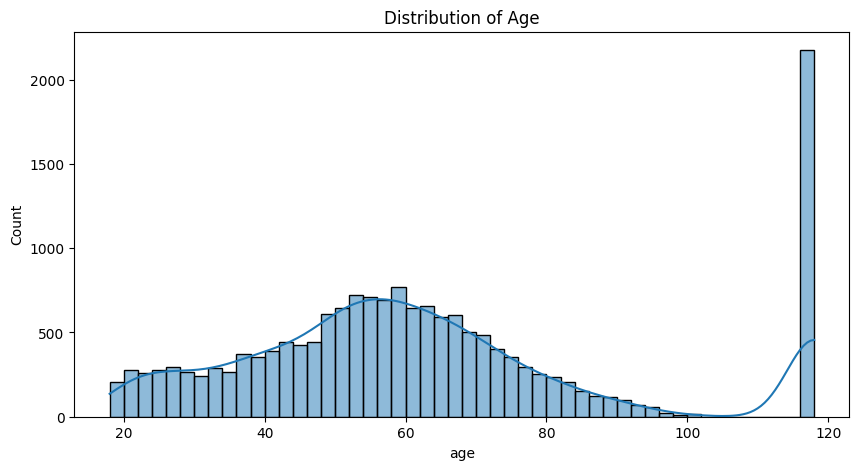

In [65]:
plt.figure(figsize = (10,5))
sns.histplot(profile['age'], bins=50, kde=True)
plt.title('Distribution of Age')
plt.savefig('fig2.png', bbox_inches='tight')
plt.show()

Age >100 is outlier, we will skip it then. The distribution major most in 50-60 

3. Statistics of type of offer distributed in event

In [30]:
transcript_portfolio = transcript.merge(portfolio, how = 'left', on = 'offer_id')

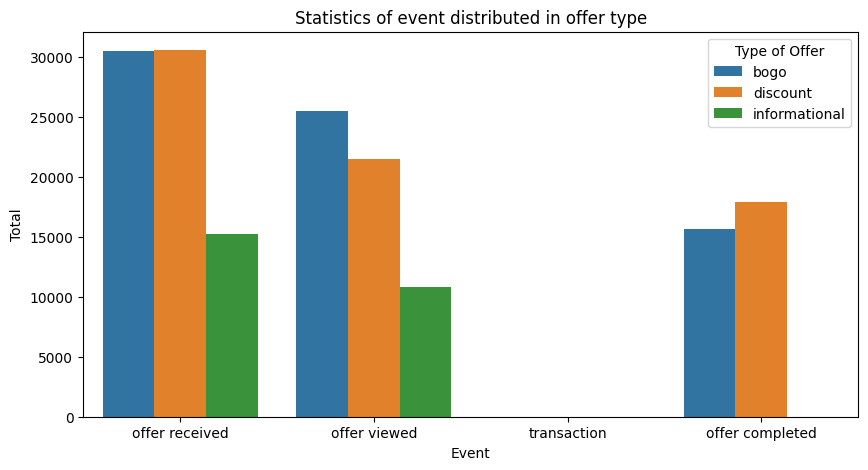

In [66]:
plt.figure(figsize=(10, 5))
sns.countplot(x=transcript_portfolio['event'], hue=transcript_portfolio['offer_type'])
plt.title('Statistics of event distributed in offer type')
plt.ylabel('Total')
plt.xlabel('Event')
plt.legend(title='Type of Offer')
plt.savefig('fig3.png', bbox_inches='tight')
plt.show()

We can see that Bogo and Discount are more popular than Informational

4. Statistics of type of offer distributed in gender

In [32]:
profile['gender'].value_counts()

M    8484
F    6129
O    2387
Name: gender, dtype: int64

Male is more than Female

In [33]:
data = transcript_portfolio.merge(profile, how = 'inner', on = 'customer_id')
data

,customer_id,event,time,amount,re,offer_id,offer_completed,reward,difficulty,duration,offer_type,email,web,social,mobile,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75,20170509,100000.000000
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75,20170509,100000.000000
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,20170509,100000.000000
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75,20170509,100000.000000
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,20170509,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,576,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,O,118,20170926,65404.991568
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,594,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,O,118,20170926,65404.991568
306531,3045af4e98794a04a5542d3eac939b1f,offer received,576,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,F,58,20161020,78000.000000
306532,3045af4e98794a04a5542d3eac939b1f,offer viewed,576,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,F,58,20161020,78000.000000


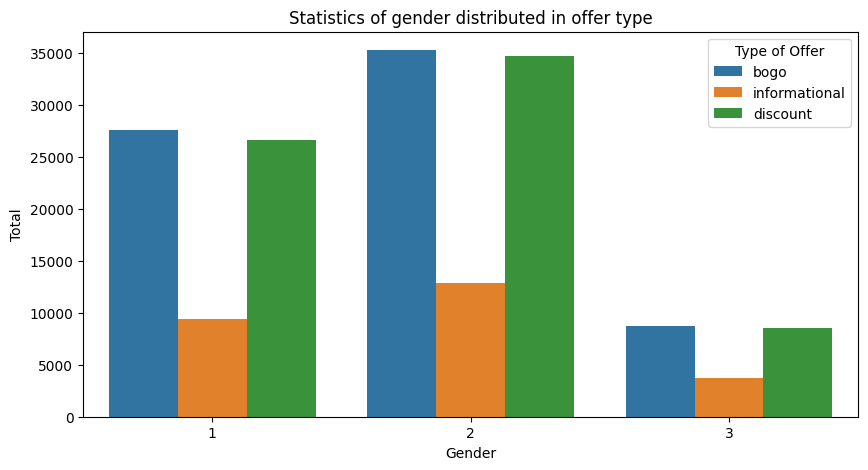

In [68]:
plt.figure(figsize=(10, 5))
sns.countplot(x=data['gender'], hue=data['offer_type'])
plt.title('Statistics of gender distributed in offer type')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.legend(title='Type of Offer')
plt.savefig('fig4.png', bbox_inches='tight')
plt.show()

Female and Male are purchased bogo and discount offer more than informational, female purchases bogo a little more then discount

# Modeling

In [36]:
data['gender'] = data['gender'].apply(lambda x: 1 if x == 'F' else 2 if (x=='M')\
                                                             else 3)


In [37]:
X = data[['time','age', 'income', 'gender']]
y =  data['offer_completed']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    306534 non-null  int64  
 1   age     306534 non-null  int64  
 2   income  306534 non-null  float64
 3   gender  306534 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 11.7 MB


In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalize_col = list(X.columns)

X[normalize_col] = scaler.fit_transform(X[normalize_col])
X.head()

/tmp/ipykernel_787883/1948055457.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[normalize_col] = scaler.fit_transform(X[normalize_col])


,time,age,income,gender
0,0.000000,0.57,0.777778,0.0
1,0.008403,0.57,0.777778,0.0
2,0.184874,0.57,0.777778,0.0
3,0.184874,0.57,0.777778,0.0
4,0.201681,0.57,0.777778,0.0


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((229900, 4), (76634, 4), (229900,), (76634,))

In [42]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, logreg_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.23%


# Conclusion

We can see that Bogo and Discount offer are more popular than Informational. We should pay attention to these offer to increase sales

Female and Male are purchased bogo and discount offer more than informational, female purchases bogo a little more then discount

The accuracy scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer based on age, time, income and gender.